# Background 

    Starting from any random Wikipedia page, following the first* page link of the current page will eventually lead you to the "Philosophy" page of Wikipedia (~95% of the time).
     
    * Due to the structure of Wikipedia articles, the first valid link must NOT:
        
        be in either parentheses (usually language pages) or italics (usually disambiguations)
        
        be a link to either a meta page, a page outside Wikipedia, or a broken link
        
        be an in-page citation
        
        
        

## Basic Goal

    Make a webcrawler that starts from a random Wikipedia page, and follows the first page link until it either finds the Philosophy page, a page with no links, or loops back to a previously visited link.
    
    Return the name of the starting page, and the degrees of separation from the Philosophy page (set degree to -1 if terminates otherwise)

        Ex. the page "Kevin Bacon" should have a degree of separation of 12
        
    NOTE: For crawling, use either the Wikipedia API or 
    
    
    You can start from a random Wikipedia page with a URL (https://en.wikipedia.org/wiki/Special:Random)   
    
   

## Tips

 
        
    Use a while-loop for the crawling, but add a maximum search number if you're still debugging it
    
    When searching for links, you're always looking at the main text of the page (use the HTML structure)
        
        
        
        

## Advanced Goals

    1.) Get the degrees of separation for 1000 random pages. Find the median degree of separation as well as the distribution.
    
    2.) Considering your results, and the size of the English Wikipedia, estimate how many pages there are of degree 6.
    
    3.) Try the Cebuano Wikipedia. Following the same rules above, determine the network structure. 
    Is there is a page that all others tend to lead back to? 
    Does it tend to loop more? 
    In any case, are the degrees generally shorter/longer?
    
        

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

# Wikipedia Crawler

## Implementation for Single Link

In [2]:
def find_philosophy(
        start_url: str = "https://en.wikipedia.org/wiki/Special:Random",
        target_url: str = "https://en.wikipedia.org/wiki/Philosophy",
) -> Tuple[str, int]:
    
	next_url = start_url
	visited_urls = set()
	degrees = 0

	try:
		options = webdriver.ChromeOptions()
		options.add_argument("--headless")
		path = "/usr/local/bin/chromedriver"
		chrome_service = webdriver.ChromeService(executable_path=path)
		driver = webdriver.Chrome(service=chrome_service, options=options)
		driver.get(start_url)
		starting_title = driver.title

		while True:
			if next_url in visited_urls:
				degrees = -1
				print("Loop detected!")
				break

			if next_url == target_url:
				print("Philosophy has been reached!")
				break

			visited_urls.add(next_url)
			driver.get(next_url)

			try:
				main_content = driver.find_element("id", "mw-content-text")
				links = main_content.find_elements(By.CSS_SELECTOR, "div.mw-parser-output > p a")

				found_valid_link = False

				for link in links[:5]:
					href = link.get_attribute("href")
					if (
						href and "/wiki" in href and
						":" not in href.split("/wiki/")[-1] and
						"cite_note" not in href
					):
						next_url = href
						found_valid_link = True
						degrees +=1
						break

				if not found_valid_link:
					degrees = -1
					print("Invalid link!")
					break

			except NoSuchElementException:
				degrees = -1
				break

			time.sleep(0.5)

	finally:
		driver.quit()

	return (starting_title, degrees)

In [3]:
results = find_philosophy(start_url="https://ceb.wikipedia.org/wiki/Special:Random")
results

Loop detected!


('Euxesta juncta - Wikipedia', -1)

## Implementation for 1000 Pages

### Median degree of separation and distribution

In [4]:
pages = {}

for i in range(2):
    if i % 10 == 0:
        print(f"Processing page {i}/1000...")
    key, value = find_philosophy()
    pages[key] = value

pd.DataFrame(list(pages.items()), columns=['first_page', 'degrees'])

Processing page 0/1000...
Philosophy has been reached!
Invalid link!


,first_page,degrees
0,Dendrobium ruckeri - Wikipedia,11
1,Stephanie Mavunga - Wikipedia,-1


In [5]:
df = pd.read_csv("results_20241027-063423.csv")
df

,first_page,degrees
0,"Campbell Township, Polk County, Missouri - Wik...",17
1,Amanzimtoti bombing - Wikipedia,13
2,Frank J. Farrell - Wikipedia,-1
3,Yamajathakudu - Wikipedia,10
4,NaN,-1
...,...,...
932,Hard to Be a God (1989 film) - Wikipedia,7
933,Mohawk Airlines Flight 411 - Wikipedia,18
934,Ālambana - Wikipedia,16
935,Saadi Town - Wikipedia,25


In [6]:
total_wiki_pages = 61718170 # according to Wikipedia

valid_degrees = df[~df['degrees'].isin([-1, -2, -3])]['degrees']
median_degree = valid_degrees.median()
degree_distribution = valid_degrees.value_counts().sort_index()

degree_6_count = len(df[df['degrees'] == 6])
degree_6_percentage = (degree_6_count / len(df)) * 100

estimated_degree_6_total = int((degree_6_percentage / 100) * total_wiki_pages)

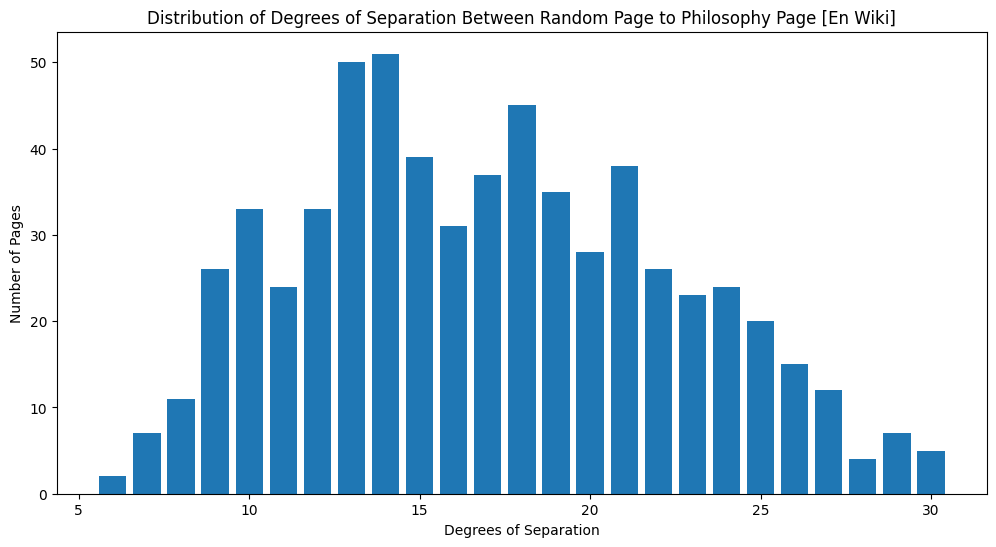

In [7]:
plt.figure(figsize=(12, 6))
plt.bar(degree_distribution.index, degree_distribution.values)
plt.title("Distribution of Degrees of Separation Between Random Page to Philosophy Page [En Wiki]")
plt.xlabel("Degrees of Separation")
plt.ylabel("Number of Pages")
plt.show()

In [8]:
print(f"Median degree of separation: {median_degree}")
print(f"\nPages with degree 6 in sample: {degree_6_count} ({degree_6_percentage:.2f}%)")
print(f"\nEstimated total Wikipedia pages with degree 6: {estimated_degree_6_total:,}")

Median degree of separation: 17.0

Pages with degree 6 in sample: 2 (0.21%)

Estimated total Wikipedia pages with degree 6: 131,735


## Cebuano Wikipedia

In [9]:
def find_philosophy(
        start_url: str = "https://ceb.wikipedia.org/wiki/Special:Random",
        target_url: str = "https://en.wikipedia.org/wiki/Philosophy",
) -> Tuple[str, int]:
    
	next_url = start_url
	last_url = next_url
	visited_urls = set()
	degrees = 0
	href_count = 0 

	try:
		options = webdriver.ChromeOptions()
		options.add_argument("--headless")
		path = "/usr/local/bin/chromedriver"
		chrome_service = webdriver.ChromeService(executable_path=path)
		driver = webdriver.Chrome(service=chrome_service, options=options)
		driver.get(start_url)
		starting_title = driver.title

		while True:
			if next_url in visited_urls:
				degrees = -1
				last_url = next_url
				print("Loop detected!")
				break

			if next_url == target_url:
				print("Philosophy has been reached!")
				break

			visited_urls.add(next_url)
			driver.get(next_url)

			try:
				main_content = driver.find_element("id", "mw-content-text")
				links = main_content.find_elements(By.CSS_SELECTOR, "div.mw-parser-output > p a")

				found_valid_link = False

				for link in links[:5]:
					href = link.get_attribute("href")
					if (
						href and "/wiki" in href and
						":" not in href.split("/wiki/")[-1] and
						"cite_note" not in href
					):
						next_url = href
						found_valid_link = True
						degrees += 1
						href_count += 1
						break

				if not found_valid_link:
					degrees = -2
					print("Invalid link!")
					break

			except NoSuchElementException:
				degrees = -3
				break

			time.sleep(0.5)

	finally:
		driver.quit()

	return (starting_title, last_url, degrees, href_count)

In [10]:
results = find_philosophy(start_url="https://ceb.wikipedia.org/wiki/Imperyong_Persyano")
results

Loop detected!


('Imperyong Persyano - Wikipedia',
 'https://ceb.wikipedia.org/wiki/Pinulongang_Romanse',
 -1,
 5)

In [11]:
pages = {}

for i in range(2):
    if i % 10 == 0:
        print(f"Processing page {i}/1000...")
    key, value1, value2, value3 = find_philosophy()
    pages[key] = {
        "last_page": value1,
        "termination": value2,
        "href_count": value3,
    }

Processing page 0/1000...
Loop detected!
Loop detected!


In [12]:
df = pd.DataFrame.from_dict(pages, orient="index").reset_index().rename(columns={"index": "start_page"})
df

,start_page,last_page,termination,href_count
0,Deserpa Flat - Wikipedia,https://ceb.wikipedia.org/wiki/Pransiya,-1,10
1,"Buffalo Branch (suba sa Tinipong Bansa, Kentuc...",https://ceb.wikipedia.org/wiki/Pransiya,-1,18


In [20]:
df = pd.read_csv("results_20241027-083929.csv")
df

,start_page,last_page,termination,href_count
0,Magogoni - Wikipedia,https://ceb.wikipedia.org/wiki/Pransiya,-1,10
1,Gagarawa (kapital sa distrito) - Wikipedia,https://ceb.wikipedia.org/wiki/Pransiya,-1,18
2,Srpnica (suba nga anhianhi sa Makedoniya) - Wi...,https://ceb.wikipedia.org/wiki/Pransiya,-1,10
3,Spring Glacier (suba sa yelo sa Kanada) - Wiki...,https://ceb.wikipedia.org/wiki/Special:Random,-2,3
4,Jebel Tizelmi - Wikipedia,https://ceb.wikipedia.org/wiki/Pransiya,-1,18
...,...,...,...,...
909,Calathus zabroides - Wikipedia,https://ceb.wikipedia.org/wiki/Inglatera,-1,6
910,Gunville Ridge - Wikipedia,https://ceb.wikipedia.org/wiki/Special:Random,-2,2
911,Čivčijeska Reka - Wikipedia,https://ceb.wikipedia.org/wiki/Special:Random,-2,1
912,Lestoniella nuevoleon - Wikipedia,https://ceb.wikipedia.org/wiki/Kinatsila,-1,6


In [21]:
termination_dict = {
    -1: "loop",
    -2: "invalid_link",
    -3: "no_element"
}

In [22]:
df["last_page"] = df["last_page"].str.split("wiki/").str[1]
df["termination"] = df["termination"].map(termination_dict)
df

,start_page,last_page,termination,href_count
0,Magogoni - Wikipedia,Pransiya,loop,10
1,Gagarawa (kapital sa distrito) - Wikipedia,Pransiya,loop,18
2,Srpnica (suba nga anhianhi sa Makedoniya) - Wi...,Pransiya,loop,10
3,Spring Glacier (suba sa yelo sa Kanada) - Wiki...,Special:Random,invalid_link,3
4,Jebel Tizelmi - Wikipedia,Pransiya,loop,18
...,...,...,...,...
909,Calathus zabroides - Wikipedia,Inglatera,loop,6
910,Gunville Ridge - Wikipedia,Special:Random,invalid_link,2
911,Čivčijeska Reka - Wikipedia,Special:Random,invalid_link,1
912,Lestoniella nuevoleon - Wikipedia,Kinatsila,loop,6


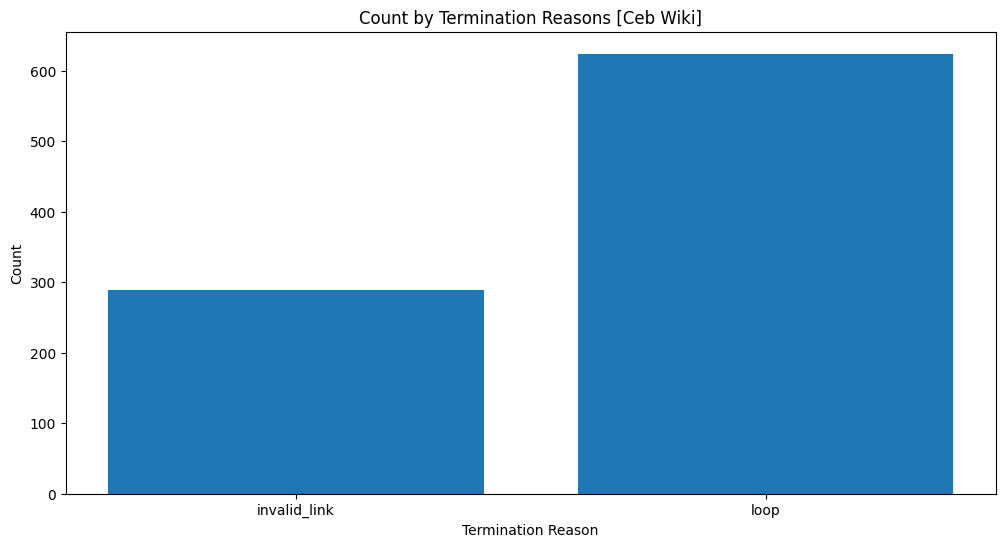

In [23]:
termination_df = df.groupby("termination").start_page.count().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(termination_df.termination, termination_df.start_page)
plt.title("Count by Termination Reasons [Ceb Wiki]")
plt.xlabel("Termination Reason")
plt.ylabel("Count")
plt.show()

Most links terminate after encountering a loop, while others lead to invalid links.

In [24]:
top_loop = df["last_page"].value_counts().index[0]
avg_degree_distribution = df["href_count"].mean()
median_degree_distribution = df["href_count"].median()

degree_distribution = df["href_count"].value_counts().sort_index()

In [25]:
print(f"Top page where others lead back to: {top_loop}")
print(f"\nAverage degree of separation: {avg_degree_distribution}")
print(f"\nMedian degree of separation: {median_degree_distribution}")

Top page where others lead back to: Pransiya

Average degree of separation: 9.272428884026258

Median degree of separation: 10.0


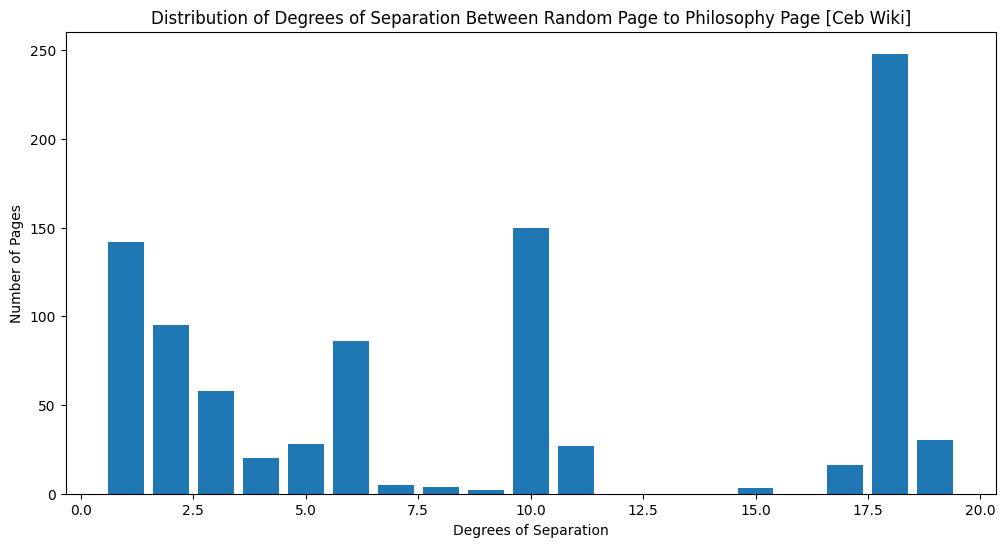

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(degree_distribution.index, degree_distribution.values)
plt.title("Distribution of Degrees of Separation Between Random Page to Philosophy Page [Ceb Wiki]")
plt.xlabel("Degrees of Separation")
plt.ylabel("Number of Pages")
plt.show()